# Transfer Learning on Fashion MNIST
---

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Global Configs

In [4]:
size = 224
DATAPATH = "../data/FashionMNIST/"

In [5]:
is_sample = True
if is_sample: PATH = DATAPATH+'sample'

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

## Load Dataset

In [8]:
data = torchvision.datasets.FashionMNIST(DATAPATH,
                                         download=True)

In [9]:
test = torchvision.datasets.FashionMNIST(DATAPATH,
                                         train=False)

## Data Exploration

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's look at the class distribution...

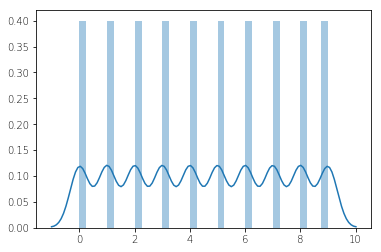

In [10]:
sns.distplot(data.train_labels)

We find an equal distribution for all classes i.e. 6000 for all 10 fashion classes

Let's look at the images...

In [11]:
def plot_images(imgs, figsize=(12,6), titles=None, maintitle=None):
    fig = plt.figure(figsize=figsize)
    imgs = np.array(imgs)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    imgs_len = len(imgs)
    for idx in range(imgs_len):
        subplt = fig.add_subplot(1, imgs_len, idx+1)
        subplt.axis('Off')
        if titles is not None:
            subplt.set_title(titles[idx], fontsize=16)
        plt.imshow(imgs[idx], cmap='gray')

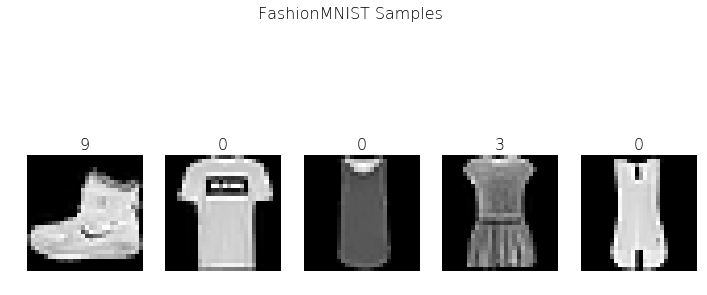

In [12]:
plot_images(data.train_data[:5],
            titles=data.train_labels[:5],
            maintitle='FashionMNIST Samples')

In [13]:
data.train_data.shape

torch.Size([60000, 28, 28])

Hence, we have 60,000 images of dimensions 28 by 28

In [27]:
labels_dict = {0: 'Top', 1: 'Trouser', 2: 'Pullover', 
               3: 'Dress', 4: 'Coat', 5: 'Sandal',
               6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boot'}

## Data Preprocessing

Here we split the dataset into sample_train, sample_valid, train and valid sets.

Sample dataset is for testing on local machine before training on the cloud. It is set by the global config SAMPLE.

In [14]:
sample_train = data.train_data[:1000]
sample_train_labels = data.train_labels[:1000]
sample_valid = data.train_data[1000:1100]
sample_valid_labels = data.train_labels[1000:1100]

In [15]:
train = data.train_data[:50000]
train_labels = data.train_labels[:50000]
valid = data.train_data[50000:60000]
valid_labels = data.train_labels[50000:60000]

Create data directory structure

In [81]:
os.mkdir(DATAPATH+'train')
os.mkdir(DATAPATH+'valid')

In [82]:
# a sample of the dataset
os.mkdir(DATAPATH+'sample/train')
os.mkdir(DATAPATH+'sample/valid')

Populate data directories

In [83]:
def imwrite_dir(images, labels, path):
    # make directory structure for labels or classes
    for label in np.unique(labels):
        os.mkdir(path+str(label))
    # put the images in the proper label directories
    for i in range(images.shape[0]):
        image = images[i]
        filepath = path+str(labels[i])+'/'+str(i)+'.jpg'
        torchvision.utils.save_image(image,
                                     filepath)

In [84]:
imwrite_dir(sample_train, sample_train_labels, DATAPATH+'sample/train/')
imwrite_dir(sample_valid, sample_valid_labels, DATAPATH+'sample/valid/')

In [85]:
imwrite_dir(train, train_labels, DATAPATH+'train/')
imwrite_dir(valid, valid_labels, DATAPATH+'valid/')

## Training Model [resnet34]

In [16]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch, size))

In [17]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      1.984007   1.025653   0.673611  



[1.0256531, 0.6736111044883728]

In [19]:
learn.save('resnet34-sample')

## Model Analysis

In [20]:
learn.load('resnet34-sample')

In [22]:
log_preds=learn.predict()
log_preds.shape

(100, 10)

In [25]:
preds = np.argmax(log_preds, axis=1)
preds[:10]

array([0, 3, 4, 2, 0, 3, 0, 0, 0, 1])

In [55]:
all_probs = {}
for key, label in labels_dict.items():
    all_probs[key] = np.exp(log_preds[:,key])

** Analysis Utilities**

In [62]:
# def rand_by_correct(is_correct=True):
#     mask = ((preds == data.val_y) == is_correct)
#     sample_idx = np.random.choice(np.where(mask)[0],
#                                   4, replace=True)
#     return sample_idx

# def most_by_correct(y, is_correct=True):
#     mask = np.where((preds == data.val_y)==is_correct
#                     & (y==data.val_y))[0]
#     sorted_idx = np.argsort(probs[mask, y])
#     return sorted_idx

def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct)
                        & (data.val_y == y), mult)

** Plot Utilities **

In [47]:
# def plots(ims, figsize=(12,6), rows=1, titles=None):
#     f = plt.figure(figsize=figsize)
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, len(ims)//rows, i+1)
#         sp.axis('Off')
#         if titles is not None: sp.set_title(titles[i], fontsize=20)
#         plt.imshow(ims[i])
        
# def load_img_id(ds, idx):
#     return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

# def plot_val_with_title(idxs, title, is_correct=True):
#     imgs = [load_img_id(data.val_ds,x) for x in idxs]
#     title_probs = [np.round(probs[x], 4) for x in idxs]
#     if is_correct:
#         title_class = np.argmax(title_probs, axis=1)
#     else:
#         title_class = np.argmin(title_probs, axis=1)
#     print(title)
#     return plots(imgs, rows=1, titles=title_class, figsize=(16,8))

In [80]:
def plots(ims, figsize=(12,6), rows=1, titles=None, main_title=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
    plt.suptitle(main_title, fontsize=24)


In [81]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs,
                 figsize=(16,8), main_title=title)

### A few correct labels at random

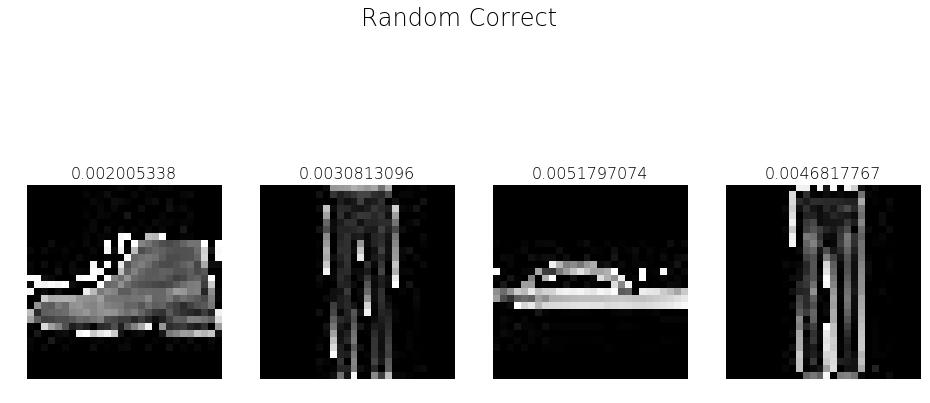

In [82]:
correct_idx = rand_by_correct(is_correct=True)
probs = all_probs[0]
plot_val_with_title(correct_idx, "Random Correct")

### A few incorrect labels at random

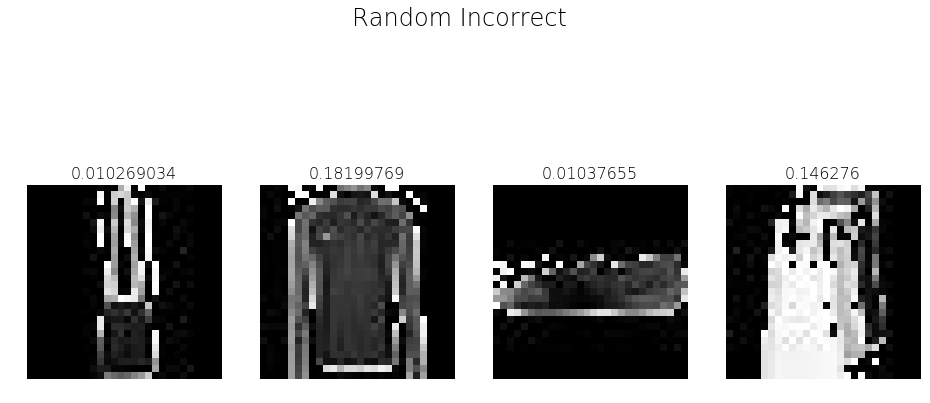

In [83]:
incorrect_idx = rand_by_correct(is_correct=False)
probs = all_probs[0]
plot_val_with_title(incorrect_idx, "Random Incorrect")

** The most correct labels of each class**

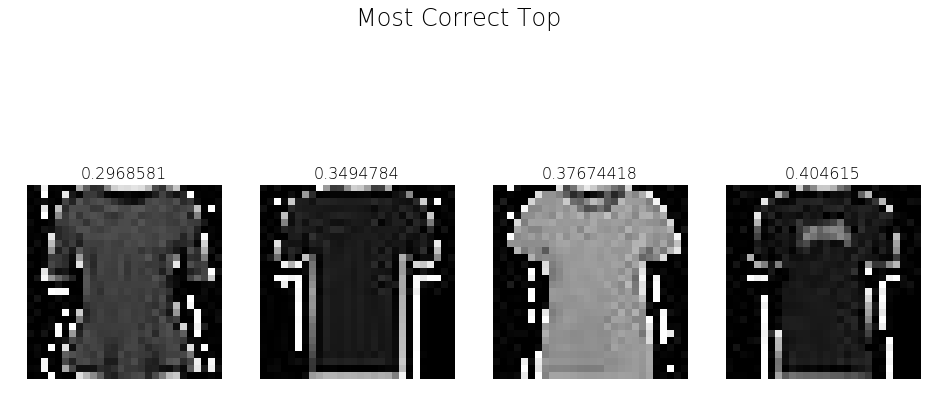

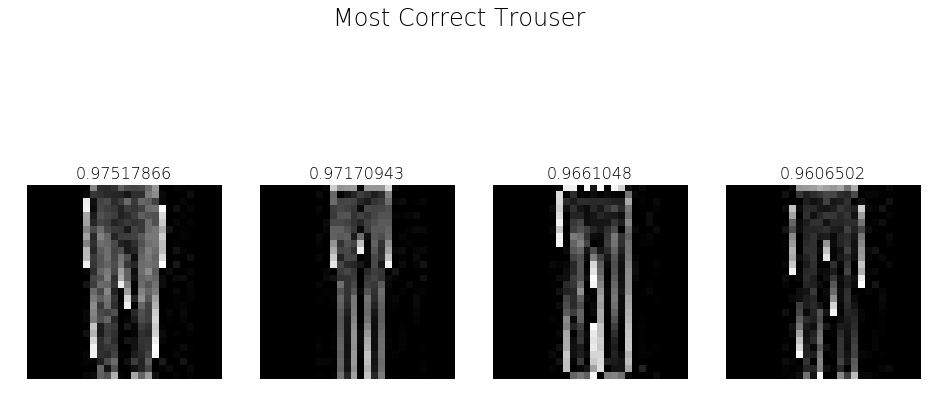

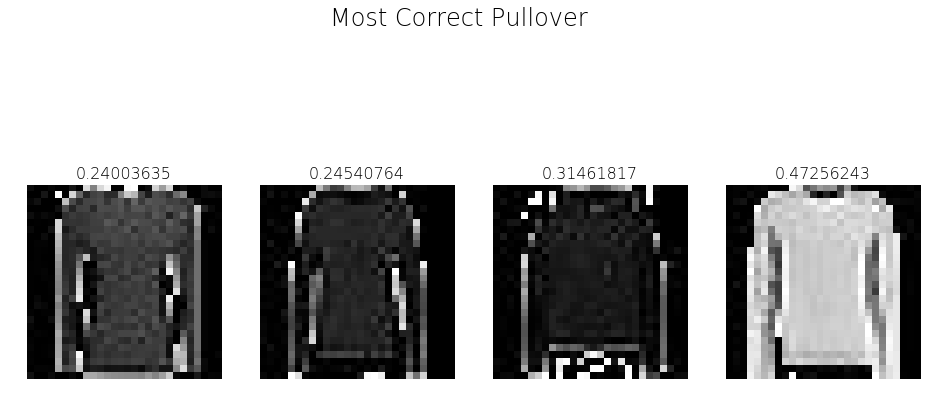

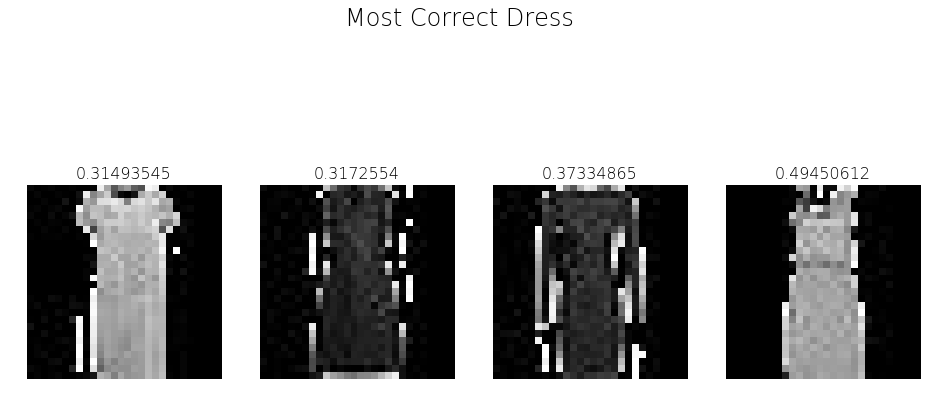

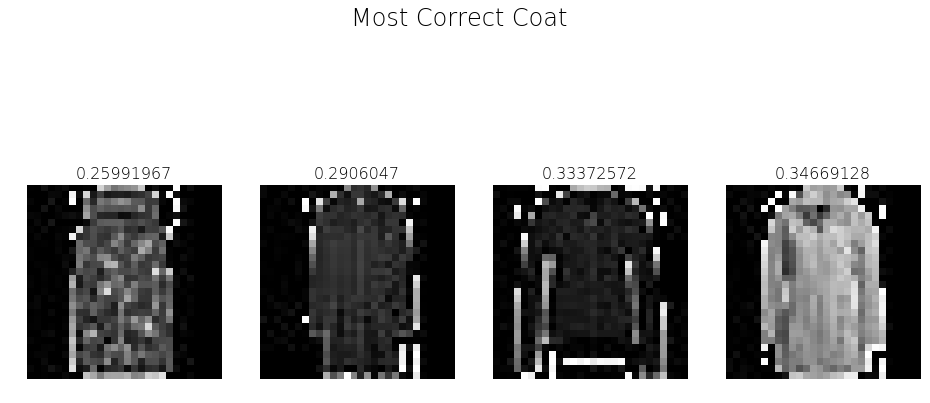

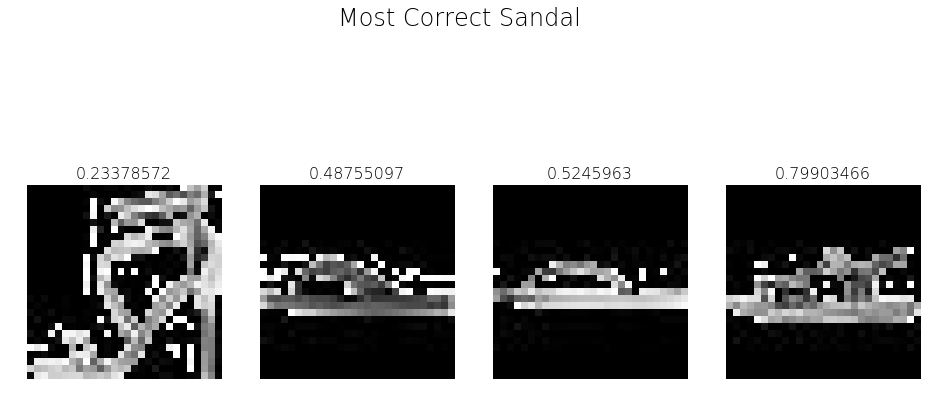

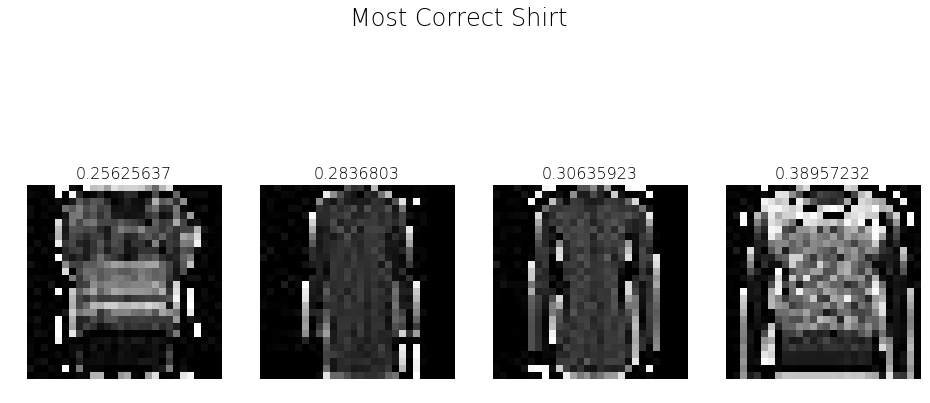

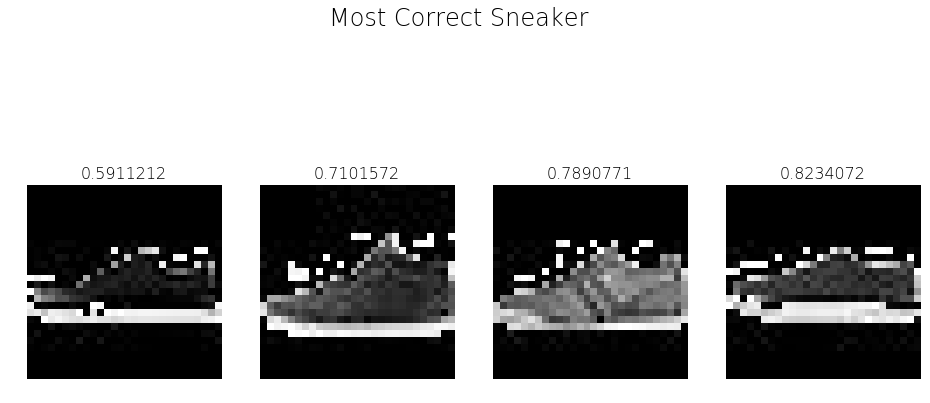

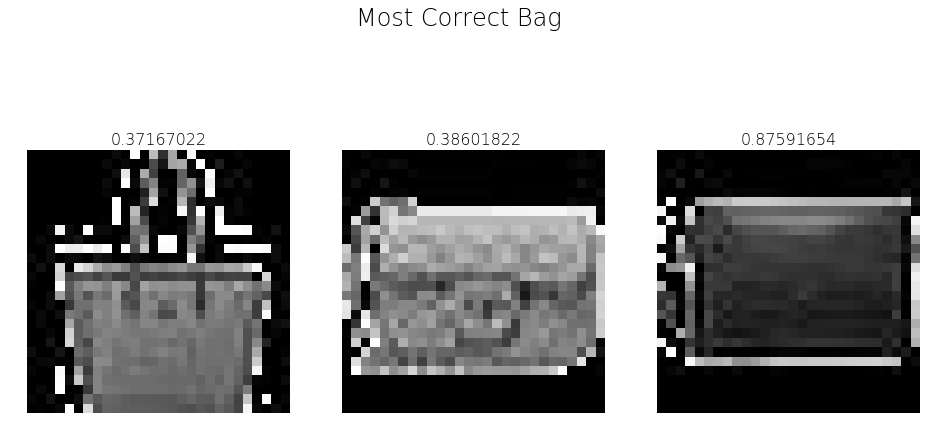

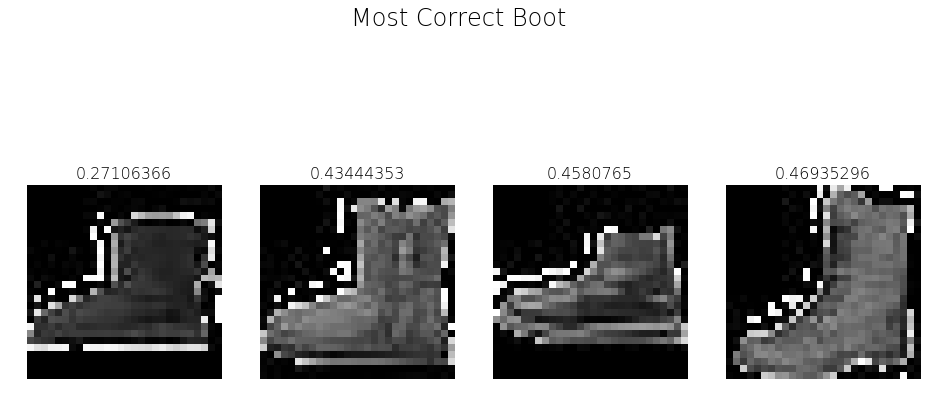

In [87]:
for key, label in labels_dict.items():
    probs=all_probs[key]
    plot_val_with_title(most_by_correct(key, True),
                        "Most Correct {}".format(label))

### TODO: The most incorrect labels of each class

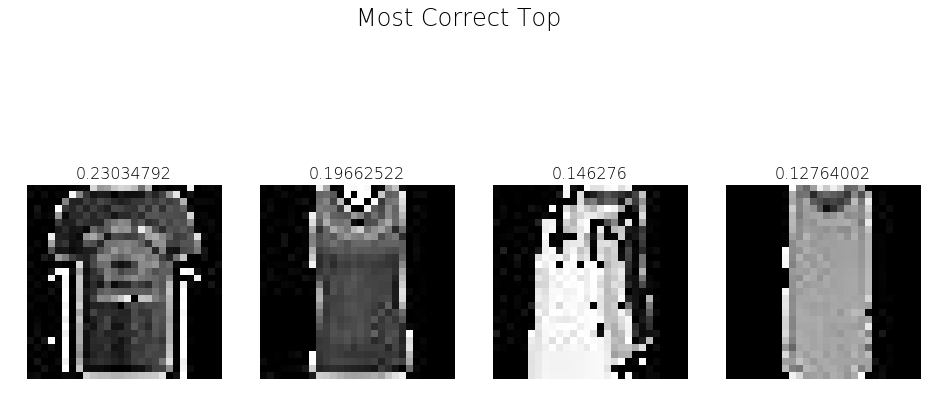

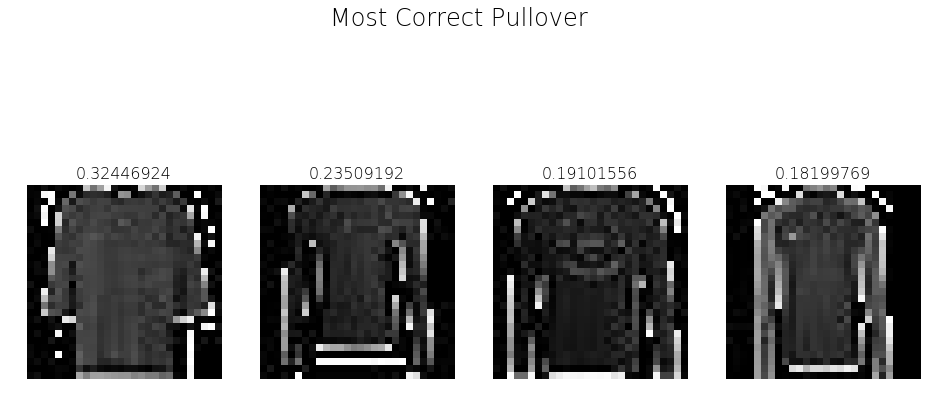

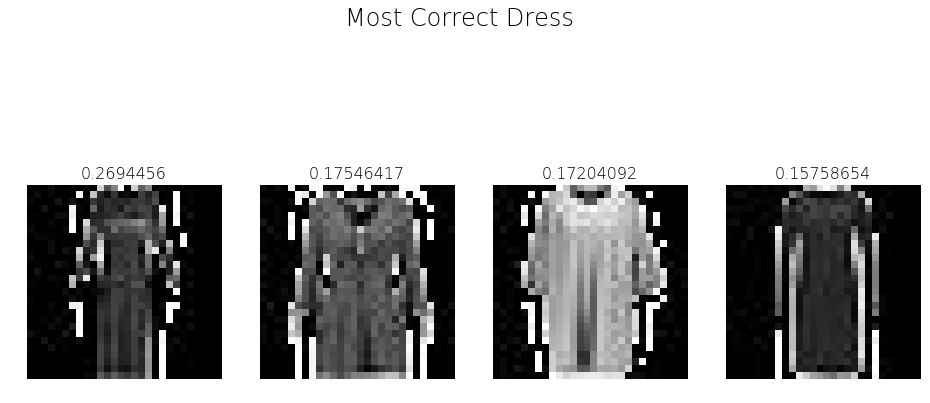

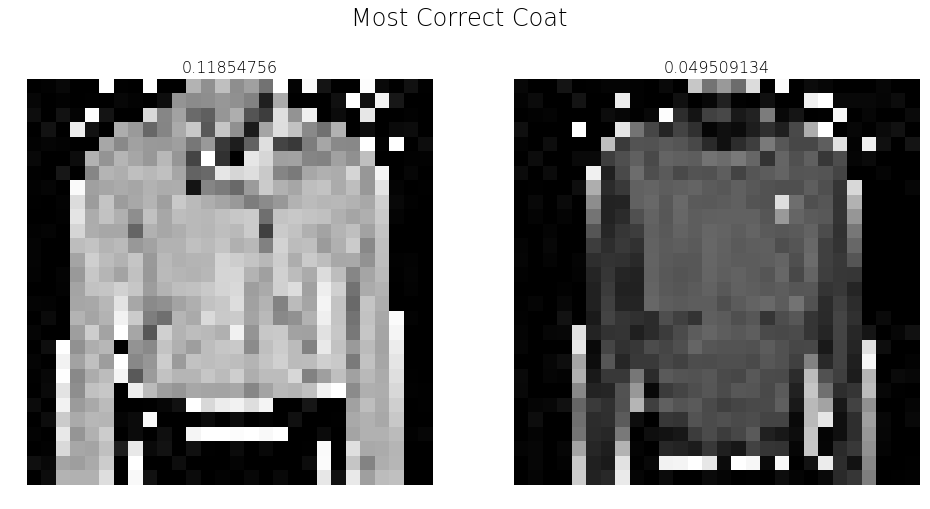

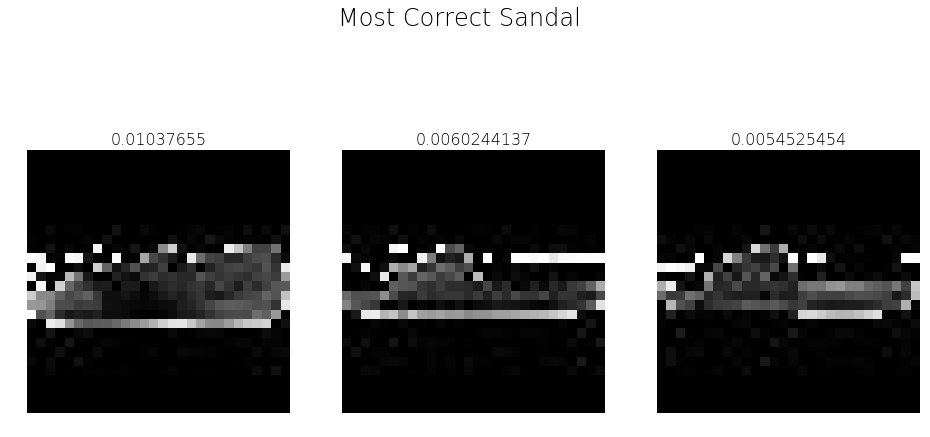

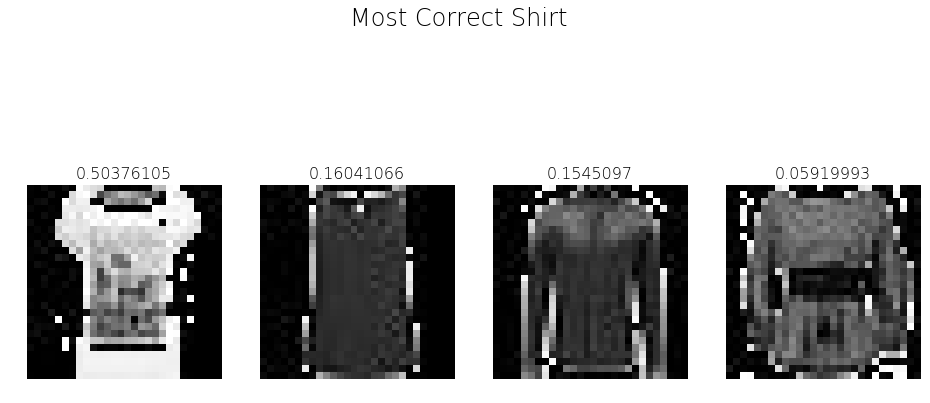

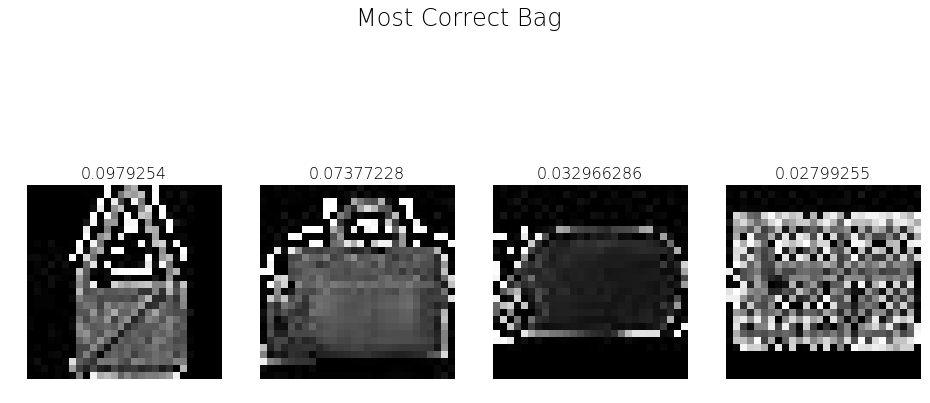

In [89]:
for key, label in labels_dict.items():
    probs=all_probs[0]
    plot_val_with_title(most_by_correct(key, False),
                        "Most Incorrect {}".format(label))

## The most uncertain labels for each class

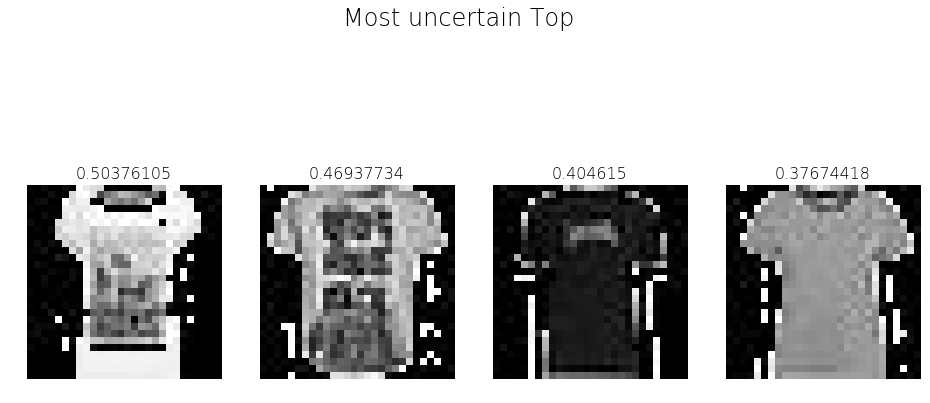

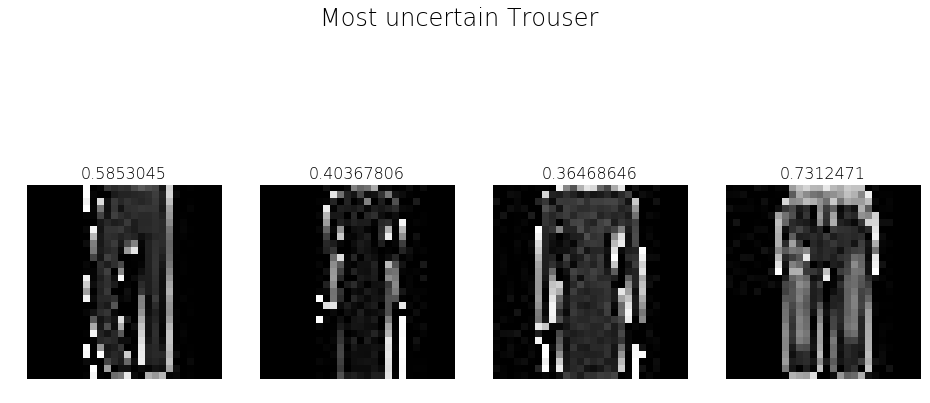

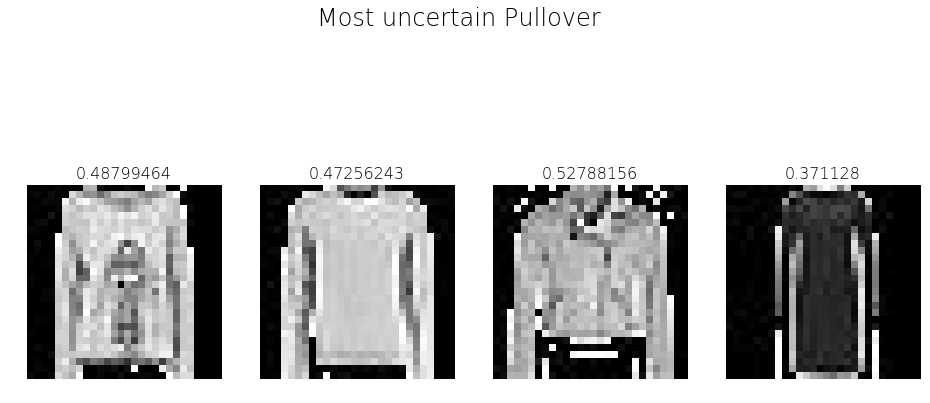

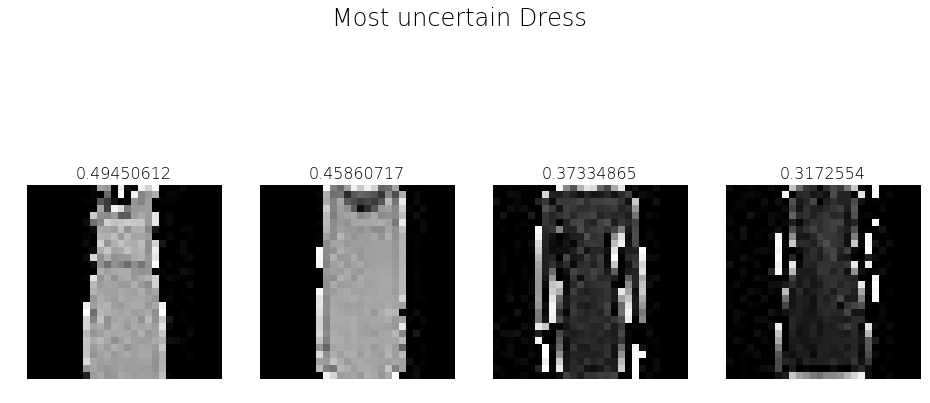

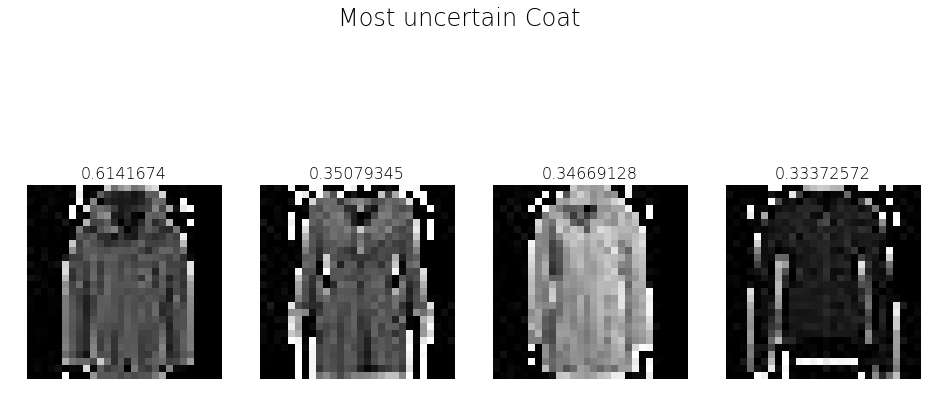

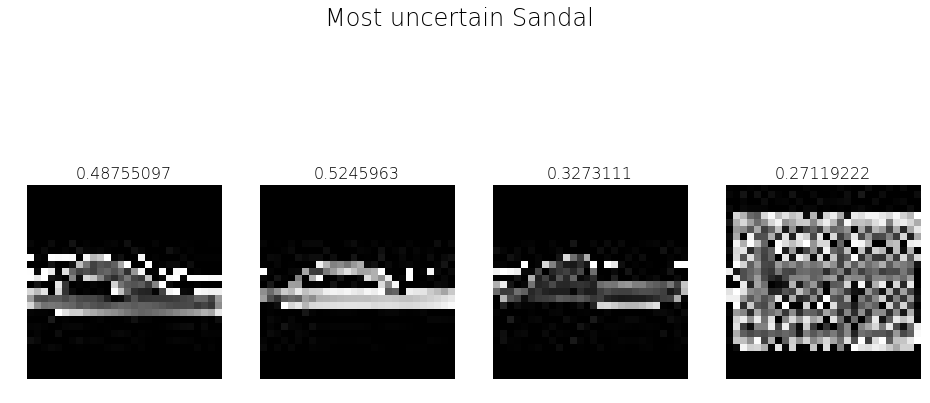

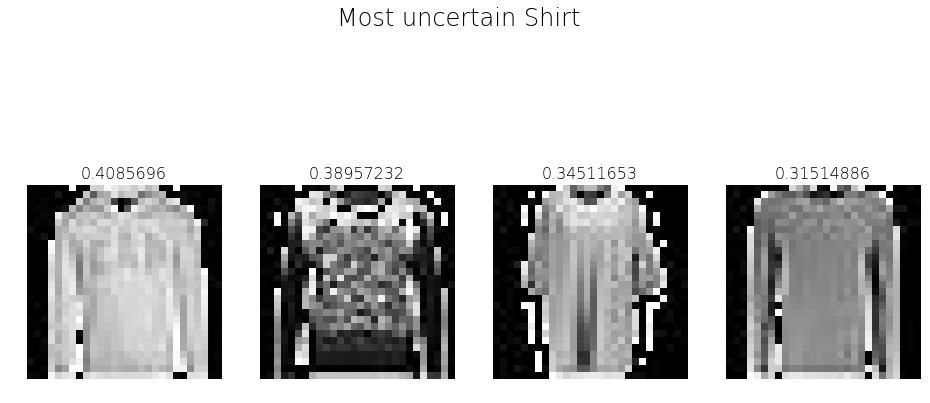

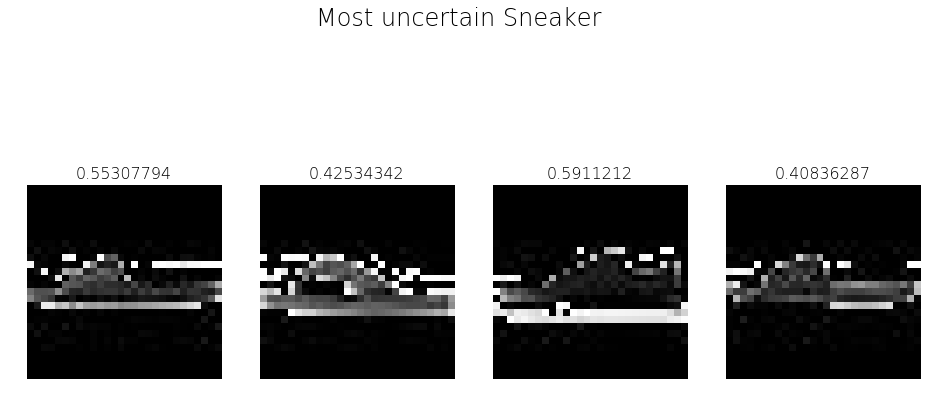

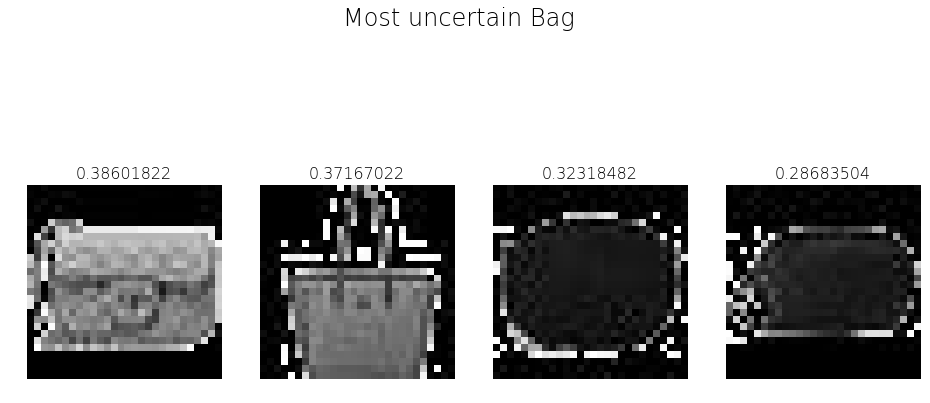

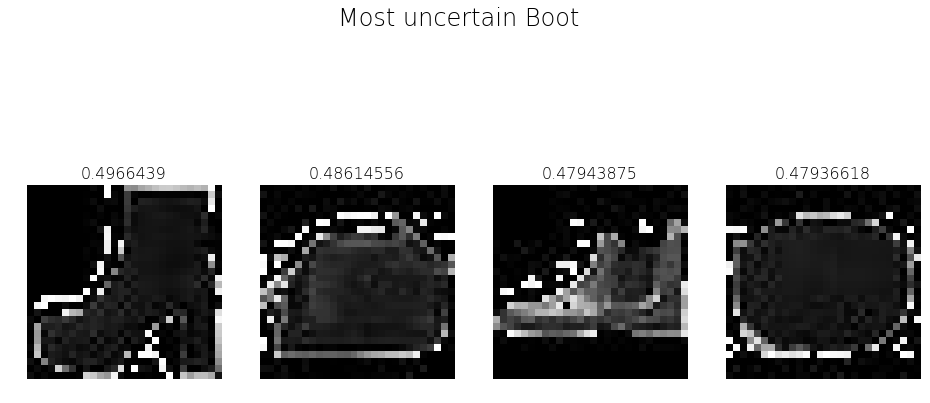

In [93]:
for key, label in labels_dict.items():
    probs = all_probs[key]
    most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
    plot_val_with_title(most_uncertain,
                        "Most uncertain {}".format(label))

## Tuning the Learning Rate